<h1 align="center">Overall Aim of this Notebook</h1>

This notebook aims to use several ML algorithms (including MARS, KNN, Linear GAM) to predict sale price using most of the features in the dataset. The notebook is split into two halves - first, we remove certain columns and see how the algorithms perform, then we add them back in and repeat the process. We finish by using the perfectly correlated columns to predict the response variable.

In [1]:
# for data manip
import numpy as np
import pandas as pd
import scipy.sparse as sp

# for preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from skrub import TableVectorizer

# modeling
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from pygam import LinearGAM, s, f
from pygam.terms import TermList
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from pyearth import Earth
from sklearn.neighbors import KNeighborsRegressor

# for pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

# for utilities
from functools import reduce
import operator

# for visualizations
import matplotlib.pyplot as plt

<h1 align="center">Load in Data and basic processing</h1>

In [2]:
df = pd.read_csv('Used_Car_Price_Prediction.csv')
df

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395,honda amaze,2018,diesel,53486,604299,ghaziabad,2756,sedan,NaN,1.5 v cvt i-dtec,...,1,630810,787750.0,great,2021-02-07T08:05:30.443,True,14036,90645,True,False
7396,maruti ignis,2018,petrol,8854,562599,chennai,640,hatchback,manual,delta 1.2 k12,...,1,549440,NaN,great,2021-03-31T10:21:56.289,True,13068,84390,False,False
7397,honda amaze,2015,petrol,46300,400499,pune,795,sedan,manual,1.2 smt i vtec,...,1,383419,NaN,great,2021-03-04T12:40:38.652,True,9303,60075,True,False
7398,maruti alto k10,2016,petrol,27245,284099,new delhi,1155,hatchback,manual,lxi,...,1,286515,369885.0,great,2021-03-16T13:31:39.766,True,6599,42615,False,False


##### We suspected that our data had null values, so the first thing that we decided to do was to find the total amount of null values.

In [3]:
print(df.isna().sum().sum())

4723


##### Once we saw that there were many null values, we decided to find out whether all columns had null values or whether they were concentrated in certain columns.

In [4]:
df.isna().sum()

car_name                  0
yr_mfr                    0
fuel_type                 0
kms_run                   0
sale_price                0
city                      0
times_viewed              0
body_type               103
transmission            556
variant                   0
assured_buy               0
registered_city          10
registered_state         10
is_hot                    0
rto                       0
source                  126
make                      0
model                     0
car_availability        620
total_owners              0
broker_quote              0
original_price         3280
car_rating                9
ad_created_on             1
fitness_certificate       8
emi_starts_from           0
booking_down_pymnt        0
reserved                  0
warranty_avail            0
dtype: int64

##### As one can see, there are 10 columns with missing values. Five of them have very few missing values (registered_city, registered_state, car_rating, ad_created_on, fitness_certificate), and the other five have a large number of missing values. We saw that the original price column had a signficant proportion of missing values (3280), so we tried dropping it later.

##### Next, we wanted to see the correlations among the continuous columns:

In [5]:
# select continous columns and find correlations
full_df_num_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[full_df_num_cols].corr()

print(correlation_matrix)

                      yr_mfr   kms_run  sale_price  times_viewed  \
yr_mfr              1.000000 -0.395842    0.518973      0.059617   
kms_run            -0.395842  1.000000   -0.104727     -0.114795   
sale_price          0.518973 -0.104727    1.000000      0.091579   
times_viewed        0.059617 -0.114795    0.091579      1.000000   
total_owners       -0.301315  0.133000   -0.131306     -0.001361   
broker_quote        0.543350 -0.126691    0.963484      0.123785   
original_price      0.508361 -0.087615    0.986005      0.103439   
emi_starts_from     0.518972 -0.104728    1.000000      0.091579   
booking_down_pymnt  0.518973 -0.104727    1.000000      0.091579   

                    total_owners  broker_quote  original_price  \
yr_mfr                 -0.301315      0.543350        0.508361   
kms_run                 0.133000     -0.126691       -0.087615   
sale_price             -0.131306      0.963484        0.986005   
times_viewed           -0.001361      0.123785        0

##### We saw that sale price has a perfect correlation with emi_starts_from and booking_down payment. So we wanted to drop those columns during our analysis. We wanted to avoid the problem of data leakage. We also tried dropping broker_quote because there was a high correlation and it might make the models unstable.

In [6]:
df_reduced = df.drop(['original_price','broker_quote', 'booking_down_pymnt', 'emi_starts_from'], axis=1) 

In [7]:
df_reduced.columns

Index(['car_name', 'yr_mfr', 'fuel_type', 'kms_run', 'sale_price', 'city',
       'times_viewed', 'body_type', 'transmission', 'variant', 'assured_buy',
       'registered_city', 'registered_state', 'is_hot', 'rto', 'source',
       'make', 'model', 'car_availability', 'total_owners', 'car_rating',
       'ad_created_on', 'fitness_certificate', 'reserved', 'warranty_avail'],
      dtype='object')

In [8]:
full_df_num_cols = df_reduced.select_dtypes(include=[np.number]).columns
correlation_matrix = df_reduced[full_df_num_cols].corr()

print(correlation_matrix)

                yr_mfr   kms_run  sale_price  times_viewed  total_owners
yr_mfr        1.000000 -0.395842    0.518973      0.059617     -0.301315
kms_run      -0.395842  1.000000   -0.104727     -0.114795      0.133000
sale_price    0.518973 -0.104727    1.000000      0.091579     -0.131306
times_viewed  0.059617 -0.114795    0.091579      1.000000     -0.001361
total_owners -0.301315  0.133000   -0.131306     -0.001361      1.000000


##### After dropping the very high correlations, the remaining correlations are now all below .7. Later in the notebook we will try to put broker quote and original price columns

##### Now we will split the dataframe into the predictor matrix and the response variable

In [9]:
# create target column and predictor matrix
X = df_reduced.drop(columns=["sale_price"])
y = df_reduced["sale_price"] 

##### Here we perform the train test split. We decided to do an 80/20 split between training and testing. We felt that we had enough data for an 80/20 split, and we have experience using an 80/20 split successfully.

In [10]:
# make train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=26       
)

<h1 align="center">Catboost Regressor</h1>

Here we start with the first algorithm, which is a catboost regressor. This algorithm is a regression model that uses gradient-boosting on decision trees to predict a continuous value by adding trees to correct the residuals from the previous models. We use table vectorizer to encode everything and then impute the missing values using the KNN imputer. We originally did a grid search here, but it took hours to run so I eventually took it out

In [11]:
# create catboost pipeline using a table vectorizer and knn imputation
pipe = Pipeline([
    ("tv", TableVectorizer()),
    ("knn", KNNImputer(n_neighbors=5)),
    ("catboost", CatBoostRegressor(
        depth=8, learning_rate=0.05, n_estimators=800,
        loss_function="RMSE", verbose=False
    ))
])

In [12]:
# fit the catboost regressor
pipe.fit(X_train, y_train)

Pipeline(steps=[('tv', TableVectorizer()), ('knn', KNNImputer()),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x17f987940>)])

In [13]:
# predict the catboost regressor on the x test set
y_pred = pipe.predict(X_test)

In [14]:
# find the RMSE and R^2 on the test set for the single catboost regressor model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 68752.863, R²: 0.944


##### We obtained an RMSE of 68752 and an R^2 of 0.944. Considering that the sale price column is in the hundred thousands, the RMSE is relatively good. We also are going to use R^2 as our primary metric in this notebook, and we believed that 94.4% for R^2 was quite good.

<h1 align="center">Ridge Regression with Polynomial Features</h1>

Now we will do ridge regression with polynomial features. Ridge regression is a regression technique where a penalty term on the coefficients that intends to reduce the magnitude of the coefficients. We separate the preprocessing into categorical and numerical, then do a grid search for the ideal hyperparameters. The hyperparameters are the degrees of the polynomial features and the strength of the penalty term.

In [15]:
# select continous and categorical columns for the ridge regression using polynomial features
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

In [16]:
# set up the ridge regression pipeline with polynomial features for the continous features
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler())
])

In [17]:
# set up the ridge regression pipeline with polynomial features for the categorical features
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore",
                          min_frequency=0.01,
                          sparse_output=True))
])

In [18]:
# set up the preprocessing for the different types of features
pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],)

In [19]:
# set up the pipeline for the ridge regression
pipe = Pipeline([
    ("pre", pre),
    ("ridge", Ridge(solver="sag", random_state=26))
])

In [20]:
# set up the parameter grid for the ridge regression grid search
param_grid = {
    "pre__num__poly__degree": [1, 2], 
    "ridge__alpha": [1.0, 10.0, 100.0]
}

In [21]:
# set up the search across the paramter grid for the ridge regression
search = GridSearchCV(
    pipe, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=26),
    scoring="neg_root_mean_squared_error",
    n_jobs=1,   
    verbose=1
)

In [22]:
# fit the grid to the training data for the ridge regression
search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['yr_mfr', 'kms_run', 'times_viewed', 'total_owners'], dtype='object')),
                                                                        ('ca...
       'assured_buy', 'registered_city', 'registered_state', 'is_hot', 'rto',
       'source', 'make', 'model', 'car_availability', 'car_rating',
       'ad_created_on', 'fitness_certificate', 'reserved', 'warranty_avail'],
      dtype='object'))])),
                                       ('ridge',
                                        Ridge(random_state=26, solver='sag'))]),
             n_jobs=1,
             param_grid={'pre__num__poly__degree': [1, 2],
                         'ridge__alpha': [1.0, 10.0, 100.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [23]:
# find the best training RMSE and best parameters
print("Best RMSE:", -search.best_score_)
print("Best params:", search.best_params_)

Best RMSE: 144558.7630434305
Best params: {'pre__num__poly__degree': 2, 'ridge__alpha': 10.0}


##### As one can see, the RMSE is higher here for the training result compared to the test result of the best catboost regressor (68752.863). We will see if the testing result is also worse.

In [24]:
# select the best performing paramters and predict the y using those
best_pipe = search.best_estimator_
y_pred = best_pipe.predict(X_test)

In [25]:
# find the test RMSE and R^2 for the ridge regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 156899.543, R²: 0.707


##### The testing R^2 for the catboost regressor was 0.944, and here you can see that the R^2 was much worse for the ridge regression model.

<h1 align="center">Linear GAM</h1>

Now we turn to the Linear GAM model. We also originally had a grid search here, but it took three hours to run. Thus, we took it out.

We begin by again splitting the data into categorical and continuous, and then we do sepearate preprocessing on them. This took a bit of fiddling, as it would often have some kind of convergence problem unless I was careful about the preprocessing.

In [26]:
# make the preprocessing pipeline for the Linear GAM model
pre = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), selector(dtype_include=np.number)),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), selector(dtype_exclude=np.number))
])

In [27]:
# make new training and testing matrices
X_tr = pre.fit_transform(X_train)
X_te = pre.transform(X_test)
y_tr = np.asarray(y_train).ravel()
n_cont = pre.named_transformers_['num'].n_features_in_
n_cat  = X_tr.shape[1] - n_cont

In [28]:
# fit the single Linear GAM model
term_pieces = [s(i, n_splines=10) for i in range(n_cont)] + \
              [f(n_cont + j) for j in range(n_cat)]
terms = reduce(operator.add, term_pieces)
gam = LinearGAM(terms, lam=1.0, max_iter=400, tol=1e-4)
gam.fit(X_tr, y_tr)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=400, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + intercept,
   tol=0.0001, verbose=False)

In [29]:
# deal with NaN numbers to allow prediction on the test data, then predict
cat_start = n_cont
cat_end = n_cont + n_cat

X_te[:, cat_start:cat_end] = np.nan_to_num(
    X_te[:, cat_start:cat_end], nan=0.0, posinf=0.0, neginf=0.0
)

mins = X_tr[:, cat_start:cat_end].min(axis=0)
maxs = X_tr[:, cat_start:cat_end].max(axis=0)
X_te[:, cat_start:cat_end] = np.clip(X_te[:, cat_start:cat_end], mins, maxs)

y_pred = gam.predict(X_te)


In [30]:
# find test RMSE and R^2 for the linear GAM
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 93708.590, R²: 0.896


##### As one can see here, the R^2 and RMSE are both worse than the catboost's performance on the test set. The R^2 for catboost regressor was 0.944 for reference.

<h1 align="center">Neural Network</h1>

Now we turn our attention to a neural network. We do separate preprocessing on the continuous and categorical variables, and then we fit the neural network. A grid search would work well here as well, although the run time was a problem so we went with just one model.

In [31]:
# select continous and categorical variables for the Neural Network
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# set up imputation for the continuous variables and also center/scale them
num_pipe = Pipeline([
    ("impute_num", KNNImputer(n_neighbors=5)),
    ("scale", StandardScaler())
])

# set up categorical imputation and one-hot encode them
cat_pipe = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# set up separate preprocessing for the different types of variables
tab = ColumnTransformer([
    ("num", num_pipe, num_sel),
    ("cat", cat_pipe, cat_sel),
])

# set up the Neural network 
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-3,            
    batch_size=256,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.15,
    random_state=26
)

# set up the overall pipeline
pipe = Pipeline([
    ("tab", tab),
    ("reg", TransformedTargetRegressor(
        regressor=mlp,
        transformer=StandardScaler()
    ))
])

In [32]:
# fit the neural network
pipe.fit(X_train, y_train)

Pipeline(steps=[('tab',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fc50760>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fc50bb0>)])),
                ('reg',
                 TransformedTargetRegressor(regressor=MLPRegressor(alpha=0.001,
                                                                   batch_size=256,
                                                                   early_stopping=True,
                                                                   hidden_layer_sizes=(256,
                                                                                       128),
                                                                   max_iter=1000,
                                                                   n_iter_no_change=20,
                                                                   random_state=26,
                                                                   validation_fraction=0.15),
                                            transformer=StandardScaler()))])

In [33]:
# predict the y values for the neural network on the test set
y_pred = pipe.predict(X_test)

In [34]:
# find the test RMSE and R^2 for the neural network
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 71143.759, R²: 0.940


##### As one can see, the Neural network is performing very well here, similar to the catboost regressor. The R^2 here was 0.940 and that of the catboost regressor was 0.944.

<h1 align="center">SVM</h1>

Here we fit a SVM model. First we start by again doing separate preprocessing on the continous and categorical variables. We went with a radial basis kernel and with a cost of 10.

In [35]:
# set up selectors for continous and categorical data (for later SVM)
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# set up a continous preprocessing pipeline
num_pipe = Pipeline([
    ("impute_num", KNNImputer(n_neighbors=5)),
    ("scale", StandardScaler())
])

# set up a categorical preprocessing pipeline
cat_pipe = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# set up a transformer for the different types of variables
tab = ColumnTransformer([
    ("num", num_pipe, num_sel),
    ("cat", cat_pipe, cat_sel),
])

# function to make the array dense to help with the SVM fitting
to_dense = FunctionTransformer(
    lambda X: X.toarray() if sp.issparse(X) else X, accept_sparse=True
)

# set up the SVM with radial basis function and given cost
svr = SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale")

# SVM pipeline
pipe_svr = Pipeline([
    ("tab", tab),
    ("dense", to_dense),  
    ("reg", TransformedTargetRegressor(
        regressor=svr,
        transformer=StandardScaler()
    ))
])

In [36]:
# fit the SVM model
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('tab',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fcac310>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fcac670>)])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x17fcd1670>)),
                ('reg',
                 TransformedTargetRegressor(regressor=SVR(C=10.0),
                                            transformer=StandardScaler()))])

In [37]:
# predict the SVM y test values
y_pred = pipe_svr.predict(X_test)

In [38]:
# find the test RMSE and R^2 for the SVM model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 81217.178, R²: 0.922


##### As one can see, the performance here is similar to those of the better models performed earlier. The R^2 was 0.922, which is slightly worse than the neural network and the catboost regressor.

<h1 align="center">MARS</h1>

Here we set up a pipeline and preprocessing for the MARS model. We did separate preprocessing for the categorical and the continuous variables.

In [39]:
# set up a pipeline for the MARS model
# make numerical and categorical selector
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# make a transformer for each type of variable
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", KNNImputer(n_neighbors=5)),  
            ("scale", StandardScaler(with_mean=True))
        ]), num_sel),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ]), cat_sel),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# make main MARS pipeline
pipe = Pipeline([
    ("prep", pre),
    ("mars", Earth(
        max_degree=2,
        enable_pruning=True,
        penalty=3,
        max_terms=13,
        minspan_alpha=0.5,
        endspan_alpha=0.5
    ))
])

In [ ]:
# fit the MARS model
pipe.fit(X_train, y_train)

In [41]:
# predict the y values on the test set for the MARS model
y_pred = pipe.predict(X_test)

In [42]:
# find the test RMSE and R^2 for the MARS model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 151423.782, R²: 0.727


##### As one can see here, the MARS model isn't performing particularly well. The R^2 of the best model so far was 0.944 for reference.

<h1 align="center">KNN</h1>

Here we do a KNN fitting. We did a grid search from k = 1 to k = 21. We were trying to find the optimal value of k that did not result in overfitting or underfitting.

In [43]:
# set up the KNN pipeline with a parameter grid and a search space
param_grid = {
    "knn__n_neighbors": list(range(1, 21))
}

#set up the KNN pipeline 
knn_pipe = Pipeline([
    ("tv", TableVectorizer()),                  
    ("impute", KNNImputer(n_neighbors=5)),      
    ("scale", StandardScaler()),                
    ("knn", KNeighborsRegressor(
        n_neighbors=10,
        weights="distance",     
        metric="minkowski", p=2
    ))
])

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    cv=5,                  
    scoring="r2",        
    n_jobs=-1,              
    verbose=False
)

In [ ]:
# fit the KNN model
knn_grid.fit(X_train, y_train)

In [45]:
# predict the test y-values
y_pred = knn_grid.predict(X_test)

In [46]:
# find the test RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

Test R²: 0.686
Test RMSE: 162393.675


##### As one can see, the R^2 is .686, which is the lowest so far. It is far lower than the current optimal result, which was 0.944.

In [47]:
# take the results for all the k values
results = knn_grid.cv_results_
k_values = results["param_knn__n_neighbors"].data
mean_scores = results["mean_test_score"]

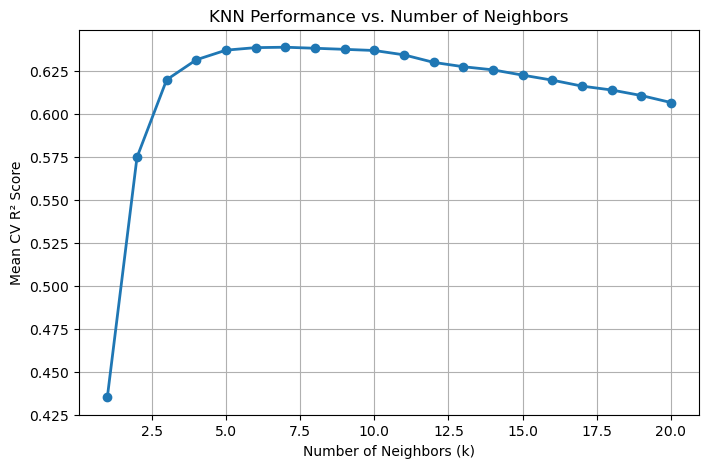

In [48]:
# graph the results
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_scores, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV R² Score")
plt.title("KNN Performance vs. Number of Neighbors")
plt.grid(True)
plt.show()

##### As one can see, the optimal k is 7, although even with that value of k the result on the test set was the worst so far.

<h1 align="center">Second Half: don't drop the two columns</h1>

Here is the second half of the notebook. In this section, we only drop the two perfectly correlated columns, but keep the other two columns: original_price and broker quote.

In [49]:
# drop only the perfectly correlated columns
df_no_leak = df.drop(['booking_down_pymnt', 'emi_starts_from'], axis=1)

In [50]:
# make the target (response) vector and the predictor matrix
X = df_no_leak.drop(columns=["sale_price"])
y = df_no_leak["sale_price"] 

In [51]:
# make the train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=26       
)

<h1 align="center">Catboost Regressor</h1>

Here we perform the catboost regressor algorithm again with the two columns added back in. Since the columns had a high correlation with the response variable, we expect them to perform better.

In [52]:
# make the single catboost regressor pipeline
pipe = Pipeline([
    ("tv", TableVectorizer()),
    ("knn", KNNImputer(n_neighbors=5)),
    ("catboost", CatBoostRegressor(
        depth=8, learning_rate=0.05, n_estimators=800,
        loss_function="RMSE", verbose=False
    ))
])

In [53]:
# fit the single catboost regressor
pipe.fit(X_train, y_train)

Pipeline(steps=[('tv', TableVectorizer()), ('knn', KNNImputer()),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x17fc3a580>)])

In [54]:
# predict the single catboost regressor model
y_pred = pipe.predict(X_test)

In [55]:
# find the test RMSE and R^2 for the single catboost regressor model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 49643.644, R²: 0.971


##### As one can see, this model is performing excellently. The R^2 value when the columns were dropped was 0.944, and now with the columns it is .971. That value for R^2 is much better than before.

<h1 align="center">Ridge Regression with Polynomial Features</h1>

Here we do the ridge regression with polynomial features again with the dropped columns (without perfect correlations) added back in.

In [56]:
# select the categorical and continous columns from the X matrix
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

In [57]:
# make a pipeline for the ridge regression on the continous variables
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler())
])

In [58]:
# make a pipeline for the ridge regression on the categorical variables
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore",
                          min_frequency=0.01,
                          sparse_output=True))
])

In [59]:
# make a preprocessing transformer for the variables for the ridge regression
pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],)

In [60]:
# make a pipeline for the ridge regression
pipe = Pipeline([
    ("pre", pre),
    ("ridge", Ridge(solver="sag", random_state=26))
])

In [61]:
# make a parameter grid for the ridge regression
param_grid = {
    "pre__num__poly__degree": [1, 2], 
    "ridge__alpha": [1.0, 10.0, 100.0]
}

In [62]:
# search over the parameter grid for the ridge regression
search = GridSearchCV(
    pipe, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=26),
    scoring="neg_root_mean_squared_error",
    n_jobs=1,   
    verbose=1
)

In [63]:
# fit the grid search for the ridge regression on the training data
search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['yr_mfr', 'kms_run', 'times_viewed', 'total_owners', 'broker_quote',
       'origin...
       'assured_buy', 'registered_city', 'registered_state', 'is_hot', 'rto',
       'source', 'make', 'model', 'car_availability', 'car_rating',
       'ad_created_on', 'fitness_certificate', 'reserved', 'warranty_avail'],
      dtype='object'))])),
                                       ('ridge',
                                        Ridge(random_state=26, solver='sag'))]),
             n_jobs=1,
             param_grid={'pre__num__poly__degree': [1, 2],
                         'ridge__alpha': [1.0, 10.0, 100.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [64]:
# show the best RMSE and parameters for the ridge regression
print("Best RMSE:", -search.best_score_)
print("Best params:", search.best_params_)

Best RMSE: 62644.4119237985
Best params: {'pre__num__poly__degree': 2, 'ridge__alpha': 10.0}


In [65]:
# make the prediction of the ys using the best model
best_pipe = search.best_estimator_
y_pred = best_pipe.predict(X_test)

In [66]:
# find the RMSE and R^2 for the best model on the test set for the ridge regression model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 48097.907, R²: 0.972


##### As one can see, this model is also performing quite well. It achieved an R^2 value of 0.707 before but now it is 0.972 with the columns added back in. It is now the highest performing model on the test set.

<h1 align="center">Linear GAM</h1>

Here we perform a fit on the linear GAM model again with the two dropped columns added back in. Since the model did well last time, we expect it to do as well or better.

In [67]:
# make the preprocessing pipeline for the Linear GAM model
pre = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), selector(dtype_include=np.number)),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), selector(dtype_exclude=np.number))
])

In [68]:
# transform all of the data so that it works with the Linear GAM model
X_tr = pre.fit_transform(X_train)
X_te = pre.transform(X_test)
y_tr = np.asarray(y_train).ravel()
n_cont = pre.named_transformers_['num'].n_features_in_
n_cat  = X_tr.shape[1] - n_cont

In [69]:
# fit the single Linear GAM model
term_pieces = [s(i, n_splines=10) for i in range(n_cont)] + \
              [f(n_cont + j) for j in range(n_cat)]
terms = reduce(operator.add, term_pieces)
gam = LinearGAM(terms, lam=1.0, max_iter=400, tol=1e-4)
gam.fit(X_tr, y_tr)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=400, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + intercept,
   tol=0.0001, verbose=False)

In [70]:
# process the test data so that we can predict on it, then predict on it using the linear GAM model
cat_start = n_cont
cat_end = n_cont + n_cat

X_te[:, cat_start:cat_end] = np.nan_to_num(
    X_te[:, cat_start:cat_end], nan=0.0, posinf=0.0, neginf=0.0
)

mins = X_tr[:, cat_start:cat_end].min(axis=0)
maxs = X_tr[:, cat_start:cat_end].max(axis=0)
X_te[:, cat_start:cat_end] = np.clip(X_te[:, cat_start:cat_end], mins, maxs)

y_pred = gam.predict(X_te)

In [71]:
# find the test RMSE and R^2 using the linear GAM model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 56204.791, R²: 0.962


##### As one can see, the R^2 value improved pretty drastically. The R^2 value before was 0.896, and now it is 0.962. Thus it is one of the better performing models currently.

<h1 align="center">Neural Network</h1>

Here we make the pipelines and fit the neural network again with the two dropped columns added back in.

In [72]:
# make a selector for the continous and categorical data
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# make a pipeline for the continous data
num_pipe = Pipeline([
    ("impute_num", KNNImputer(n_neighbors=5)),
    ("scale", StandardScaler())
])

# make a pipeline for the categorical data
cat_pipe = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# make an overall transformer for the variables
tab = ColumnTransformer([
    ("num", num_pipe, num_sel),
    ("cat", cat_pipe, cat_sel),
])

# define the parameters for the neural network
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-3,            
    batch_size=256,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.15,
    random_state=26
)

# definie the overall pipeline for the neural network
pipe = Pipeline([
    ("tab", tab),
    ("reg", TransformedTargetRegressor(
        regressor=mlp,
        transformer=StandardScaler()
    ))
])

In [73]:
# fit the neural network to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('tab',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fc37fa0>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fc37280>)])),
                ('reg',
                 TransformedTargetRegressor(regressor=MLPRegressor(alpha=0.001,
                                                                   batch_size=256,
                                                                   early_stopping=True,
                                                                   hidden_layer_sizes=(256,
                                                                                       128),
                                                                   max_iter=1000,
                                                                   n_iter_no_change=20,
                                                                   random_state=26,
                                                                   validation_fraction=0.15),
                                            transformer=StandardScaler()))])

In [74]:
# predict the y values on the test data for the neural network
y_pred = pipe.predict(X_test)

In [75]:
# find the test RMSE and R^2 for the neural network
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 44091.582, R²: 0.977


##### The neural network is doing great here like most of the models in the second half. The R^2 was 0.940 before and now it is 0.977, the highest so far.

<h1 align="center">SVM</h1>

Here we fit the SVM model again with the information from the two dropped columns added back in.

In [76]:
# make selectors for the continous and categorical data for the SVM model
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# make the pipeline for the continous data
num_pipe = Pipeline([
    ("impute_num", KNNImputer(n_neighbors=5)),
    ("scale", StandardScaler())
])

# make the pipeline for the categorical data
cat_pipe = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# make the transformer for the variables
tab = ColumnTransformer([
    ("num", num_pipe, num_sel),
    ("cat", cat_pipe, cat_sel),
])

# make the array dense to help with the SVM model
to_dense = FunctionTransformer(
    lambda X: X.toarray() if sp.issparse(X) else X, accept_sparse=True
)

# define the kernel for SVM given a cost and epsilon
svr = SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale")

# define the overall SVM pipeline
pipe_svr = Pipeline([
    ("tab", tab),
    ("dense", to_dense),  
    ("reg", TransformedTargetRegressor(
        regressor=svr,
        transformer=StandardScaler()
    ))
])

In [77]:
# fit the SVM model
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('tab',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fa54220>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17fa54460>)])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x17f97cdc0>)),
                ('reg',
                 TransformedTargetRegressor(regressor=SVR(C=10.0),
                                            transformer=StandardScaler()))])

In [78]:
# predict the y values for the SVM model
y_pred = pipe_svr.predict(X_test)

In [79]:
# find the test RMSE and R^2 for the SVM model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 52378.372, R²: 0.967


##### As one can see, the SVM model is doing quite well. Its R^2 before was 0.922 and now it is 0.967. It isn't the highest performing model in the second half, but it is definitely one of the stronger models.

<h1 align="center">MARS</h1>

Here we fit the MARS model again with the two columns added back into the dataset. We felt that since MARS is usually a pretty strong model, it might do better with the added signal from the two dropped columns.

In [80]:
# set up a pipeline for the MARS model
# make numerical and categorical selector
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# make a transformer for each type of variable
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", KNNImputer(n_neighbors=5)),  
            ("scale", StandardScaler(with_mean=True))
        ]), num_sel),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ]), cat_sel),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# make main MARS pipeline
pipe = Pipeline([
    ("prep", pre),
    ("mars", Earth(
        max_degree=2,
        enable_pruning=True,
        penalty=3,
        max_terms=13,
        minspan_alpha=0.5,
        endspan_alpha=0.5
    ))
])

In [ ]:
# fit the MARS model
pipe.fit(X_train, y_train)

In [82]:
# predict the y values on the test set for the MARS model
y_pred = pipe.predict(X_test)

In [83]:
# find the test RMSE and R^2 for the MARS model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 41793.244, R²: 0.979


##### As one can see, the MARS model has significantly improved its performance. Its R^2 before was 0.727, but now it is 0.979 - the highest so far!

<h1 align="center">KNN</h1>

Here we do our KNN prediction, again with a grid search from k=1 to k=21 with the two dropped columns added back in.

In [84]:
# set up the KNN pipeline with a parameter grid and a search space
param_grid = {
    "knn__n_neighbors": list(range(1, 21))
}

#set up the KNN pipeline 
knn_pipe = Pipeline([
    ("tv", TableVectorizer()),                  
    ("impute", KNNImputer(n_neighbors=5)),      
    ("scale", StandardScaler()),                
    ("knn", KNeighborsRegressor(
        n_neighbors=10,
        weights="distance",     
        metric="minkowski", p=2
    ))
])

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    cv=5,                  
    scoring="r2",        
    n_jobs=-1,              
    verbose=False
)

In [ ]:
# fit the KNN model
knn_grid.fit(X_train, y_train)

In [86]:
# predict the y values using the KNN model
y_pred = knn_grid.predict(X_test)

In [87]:
# find the test RMSE and R^2 using the KNN model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

RMSE: 145962.806, R²: 0.746


In [88]:
# take the results for all the k values
results = knn_grid.cv_results_
k_values = results["param_knn__n_neighbors"].data
mean_scores = results["mean_test_score"]

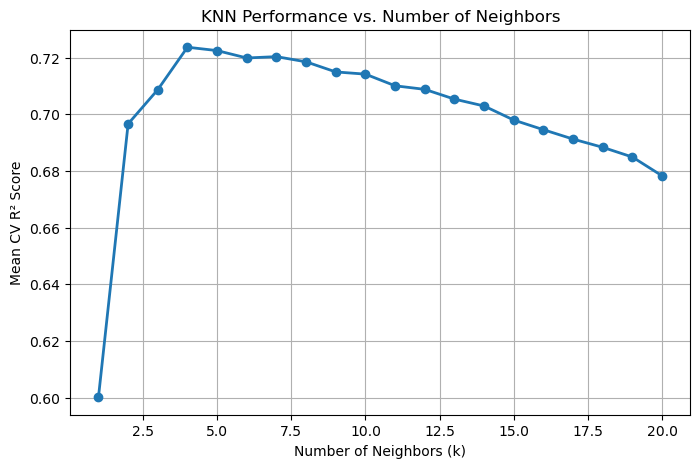

In [89]:
# graph the results
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_scores, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV R² Score")
plt.title("KNN Performance vs. Number of Neighbors")
plt.grid(True)
plt.show()

##### As one can see, KNN is still not doing very well. Its R^2 before was 0.686 but now is 0.746. It is the lowest so far.

<h1 align="center">Look at the Perfectly Correlated columns</h1>

Here we do a simple linear regression on the perfectly correlated columns. We expect to get a meaningful relationship here such as 10% down for booking down payment and a monthly installment of 5%.

#### We will start with an analysis of the emi starts from column. By the way, emi stands for equated monthly installment.

In [90]:
df

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395,honda amaze,2018,diesel,53486,604299,ghaziabad,2756,sedan,NaN,1.5 v cvt i-dtec,...,1,630810,787750.0,great,2021-02-07T08:05:30.443,True,14036,90645,True,False
7396,maruti ignis,2018,petrol,8854,562599,chennai,640,hatchback,manual,delta 1.2 k12,...,1,549440,NaN,great,2021-03-31T10:21:56.289,True,13068,84390,False,False
7397,honda amaze,2015,petrol,46300,400499,pune,795,sedan,manual,1.2 smt i vtec,...,1,383419,NaN,great,2021-03-04T12:40:38.652,True,9303,60075,True,False
7398,maruti alto k10,2016,petrol,27245,284099,new delhi,1155,hatchback,manual,lxi,...,1,286515,369885.0,great,2021-03-16T13:31:39.766,True,6599,42615,False,False


In [91]:
# here we choose the regressor as "emi starts from"
X = df[["emi_starts_from"]]
y = df["sale_price"] 

In [92]:
# do a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [93]:
# fit the linear model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [94]:
# predict the y value for the linear model
y_pred = model.predict(X_test)

In [95]:
# find the test RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# You can also access the model's coefficients and intercept
print(f"Coefficient (slope): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

Root Mean Squared Error: 12.37
R-squared: 1.00
Coefficient (slope): 43.05
Intercept: 0.08


##### As one can see, it has an R^2 of 1 with a perfect correlation. Since the intercept is close to 0, we could interpret it as meaning that the loan for the cars is supposed to be paid off after 43 months.

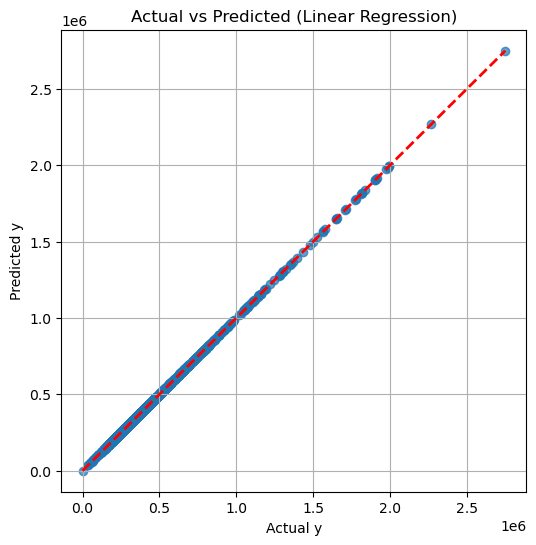

In [96]:
# make a graph of the actual versus predicted y
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2) 
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Actual vs Predicted (Linear Regression)")
plt.grid(True)
plt.show()

##### As one can see, it is a deterministic relationship which would be expected for a monthly installment for a car loan.

#### Now we will do booking_down_pymnt as the regressor and determine the relationship between it and the response variable.

In [97]:
# make the regressor as the booking down payment
X = df[["booking_down_pymnt"]]
y = df["sale_price"] 

In [98]:
# make the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [99]:
# fit the linear model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [100]:
# predict the y values
y_pred = model.predict(X_test)

In [101]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# You can also access the model's coefficients and intercept
print(f"Coefficient (slope): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

Root Mean Squared Error: 0.57
R-squared: 1.00
Coefficient (slope): 6.67
Intercept: -0.57


##### As one can see, this is another deterministic relationship. It seems that the down payment is 1/6.67 or around 15% of the sale price.

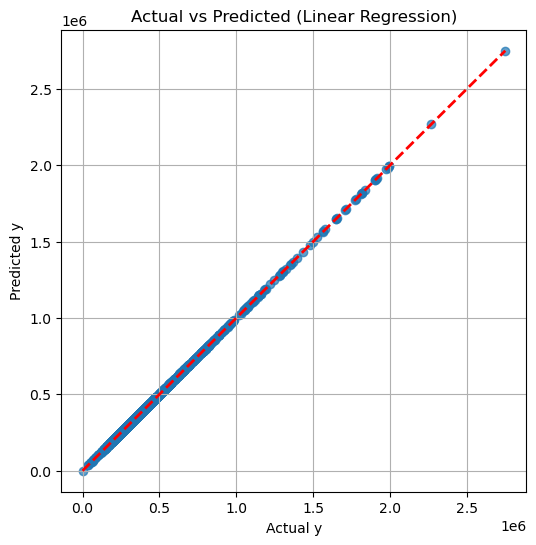

In [102]:
# make a graph of the actual versus predicted y
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2) 
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Actual vs Predicted (Linear Regression)")
plt.grid(True)
plt.show()

##### You can see that the booking down payment is another deterministic relationship with the response variable sale price.

In summary, we performed catboost regressor, ridge regression, linear GAM, neural network, SVM, MARS, and KNN regression on the predictor matrix in order to predict the sale price response variable. After some initial analyses, we discovered that two of the columns were perfectly correlated with the response variable and also that they probably would be considered as data leakage were they to be kept in the predictor matrix. We dropped the two perfectly correlated columns and also two highly correlated columns. We performed the regression with those four columns dropped and then again with the two highly correlated columns added back in. Both halves were successful, although all of the models performed better with the two highly correlated features added back in, signifying that pretty strong signal was contained in them. The best model overall was the MARS model with the two features added back in. Additionally, we discovered the formula relating emi_starts_from and booking_down_payment to the response variable in a deterministic fashion.

Further work could be done in performing a wider grid search for the models where grid search was applied. We initially had a wider grid for most of them, but we kept scaling them back because long runtimes were becoming an issue. Some of the models had their grid searches taken out entirely, and it would certainly be interesting to add them back in and see if we could achieve even better performance. It would also be interesting to do lasso regression or elastic net regression, as the ridge regression was able to achieve good results.